# T-Drive trajectory data sample

https://www.microsoft.com/en-us/research/publication/t-drive-trajectory-data-sample/?from=http%3A%2F%2Fresearch.microsoft.com%2Fapps%2Fpubs%2F%3Fid%3D152883

August 12, 2011

This is a sample of T-Drive trajectory dataset that contains a one-week trajectories of 10,357 taxis. The total number of points in this dataset is about 15 million and the total distance of the trajectories reaches 9 million kilometers.

Please cite the following papers when using the dataset:

[1] Jing Yuan, Yu Zheng, Xing Xie, and Guangzhong Sun. Driving with knowledge from the physical world. In The 17th ACM SIGKDD international conference on Knowledge Discovery and Data mining, KDD’11, New York, NY, USA, 2011. ACM.

[2] Jing Yuan, Yu Zheng, Chengyang Zhang, Wenlei Xie, Xing Xie, Guangzhong Sun, and Yan Huang. T-drive: driving directions based on taxi trajectories. In Proceedings of the 18th SIGSPATIAL International Conference on Advances in Geographic Information Systems, GIS ’10, pages 99-108, New York, NY, USA,2010. ACM.


Adapted from: http://nbviewer.jupyter.org/github/roryhr/taxi-trajectories/blob/master/taxi-data-notebook.ipynb

# Import libraries

In [58]:
# Scientific computing
import pandas as pd
import geopandas as gpd
import numpy as np
import math

# Visualization 
import seaborn as sns
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_notebook, show
output_notebook()
import datashader as ds
import datashader.transfer_functions as tf
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno

# Utilities
import os
import glob
import zipfile
from tqdm import tqdm

# Enable inline plots
%matplotlib inline

Loading BokehJS ...

In [38]:
# Function that return a list of files to read in a given folder
def get_files(direc):
    full_files = []
    for root, dirs, files in os.walk(direc):
        for name in files:
            full_files.append(os.path.join(root, name))
        
    return full_files

In [39]:
data_path = "../data/release/taxi_log_2008_by_id/"

In [40]:
full_files = get_files(data_path)           # All folders: 700 MB

print "Reading in the .txt files..."

data = []
for index, file_path in tqdm(enumerate(full_files)):
    data.append(pd.read_csv(file_path, infer_datetime_format=True,\
            header=None, parse_dates = [1],\
            names = ['taxi_id', 'date_time', 'longitude', 'latitude']))

data = pd.concat(data, ignore_index=True)

print "Size of data frame: ", data.shape
print "%.1f million rows" % (data.shape[0]/1.0e6)

25it [00:00, 245.94it/s]

Reading in the .txt files...


10357it [00:42, 244.74it/s]


Size of data frame:  (17662984, 4)
17.7 million rows


In [41]:
data.head()

,taxi_id,date_time,longitude,latitude
0,1,2008-02-02 15:36:08,116.51172,39.92123
1,1,2008-02-02 15:46:08,116.51135,39.93883
2,1,2008-02-02 15:46:08,116.51135,39.93883
3,1,2008-02-02 15:56:08,116.51627,39.91034
4,1,2008-02-02 16:06:08,116.47186,39.91248


In [42]:
data.tail()

,taxi_id,date_time,longitude,latitude
17662979,9999,2008-02-08 17:11:13,116.27644,39.99720
17662980,9999,2008-02-08 17:16:15,116.28298,39.99740
17662981,9999,2008-02-08 17:21:17,116.28896,39.99235
17662982,9999,2008-02-08 17:26:19,116.28925,39.98273
17662983,9999,2008-02-08 17:36:23,116.26768,39.90663


In [43]:
def count_number_of_hours(df):
    print "The dataset spans", len(df.resample('h', on='date_time').index), "hours."

In [44]:
count_number_of_hours(data)

The dataset spans

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
.resample() is now a deferred operation
You called index(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead
  


 149 hours.


# Process the data

In [45]:
data.dtypes

taxi_id              object
date_time    datetime64[ns]
longitude           float64
latitude            float64
dtype: object

In [47]:
def process_data(df):
    
    df['end_time'] = df['date_time'].shift(-1)
    df['end_lat'] = df['latitude'].shift(-1)
    df['end_lon'] = df['longitude'].shift(-1)
    
    # Drop the last row for each taxi id
    df['taxi_id_prev'] = df['taxi_id'].shift(-1)
    df['id_check'] = (df['taxi_id'] == df['taxi_id_prev'])
    df = df[df['id_check'] == True]

    # Clean up data
    del df['taxi_id_prev']
    del df['id_check']
    df = df.reset_index(drop=True)
    df.columns = ['taxi_id', 'start_time', 'start_lon', 'start_lat','end_time','end_lat','end_lon']
    
    # Calculate duration
    df['duration'] = (df['end_time'] - df['start_time']).dt.total_seconds()

    return df

In [48]:
trips = process_data(data)

In [49]:
#trips.to_csv("/Users/will/Documents/OpenFrameworks/apps/myApps/BeijingTaxiTrips/bin/data/trips.csv")

In [50]:
trips.head()

,taxi_id,start_time,start_lon,start_lat,end_time,end_lat,end_lon,duration
0,1,2008-02-02 15:36:08,116.51172,39.92123,2008-02-02 15:46:08,39.93883,116.51135,600.0
1,1,2008-02-02 15:46:08,116.51135,39.93883,2008-02-02 15:46:08,39.93883,116.51135,0.0
2,1,2008-02-02 15:46:08,116.51135,39.93883,2008-02-02 15:56:08,39.91034,116.51627,600.0
3,1,2008-02-02 15:56:08,116.51627,39.91034,2008-02-02 16:06:08,39.91248,116.47186,600.0
4,1,2008-02-02 16:06:08,116.47186,39.91248,2008-02-02 16:16:08,39.92498,116.47217,600.0


# Visualize the trips

In [62]:
trips.head()

,taxi_id,start_time,start_lon,start_lat,end_time,end_lat,end_lon,duration
0,1,2008-02-02 15:36:08,116.51172,39.92123,2008-02-02 15:46:08,39.93883,116.51135,600.0
1,1,2008-02-02 15:46:08,116.51135,39.93883,2008-02-02 15:46:08,39.93883,116.51135,0.0
2,1,2008-02-02 15:46:08,116.51135,39.93883,2008-02-02 15:56:08,39.91034,116.51627,600.0
3,1,2008-02-02 15:56:08,116.51627,39.91034,2008-02-02 16:06:08,39.91248,116.47186,600.0
4,1,2008-02-02 16:06:08,116.47186,39.91248,2008-02-02 16:16:08,39.92498,116.47217,600.0


In [54]:
def clipDataToBoundingBox(df, bbox):
    min_lon, min_lat, max_lon, max_lat = bbox
    clipped = df[((df['start_lat'] >= min_lat) & (df['start_lat'] <= max_lat) &\
                  (df['start_lon'] >= min_lon) & (df['start_lon'] <= max_lon) &\
                  (df['end_lat'] >= min_lat)   & (df['end_lat']   <= max_lat) &\
                  (df['end_lon'] >= min_lon)   & (df['end_lon']   <= max_lon))]
    return clipped

In [66]:
bejing_bbox = [116.018372,39.640595,116.717377,40.179923]
trips_clipped = clipDataToBoundingBox(trips, bejing_bbox)

Beijing Taxi Pickups


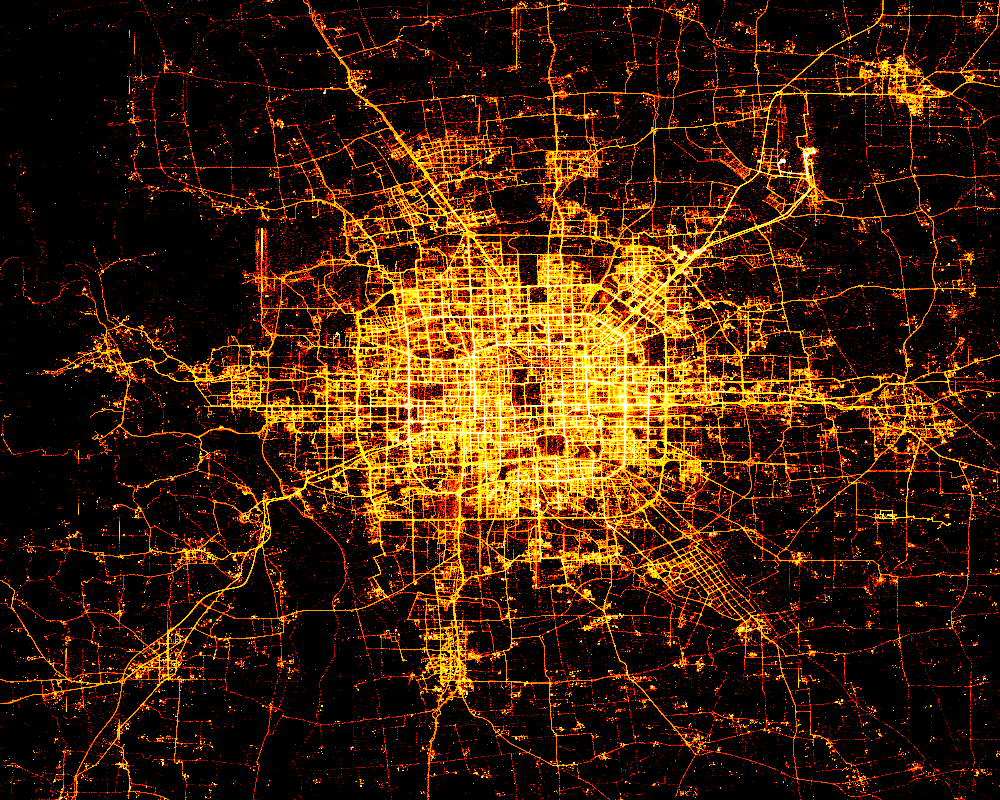

In [69]:
background = "black"
export = partial(export_image, background = background)
cm = partial(colormap_select, reverse=(background!="black"))
cvs = ds.Canvas(plot_width=1000, plot_height=800)
agg = cvs.points(trips_clipped, 'start_lon', 'start_lat')
print "Beijing Taxi Pickups"
export(tf.shade(agg, cmap = cm(Hot,0.2), how='eq_hist'),"passenger_count")

Beijing Taxi Dropoffs


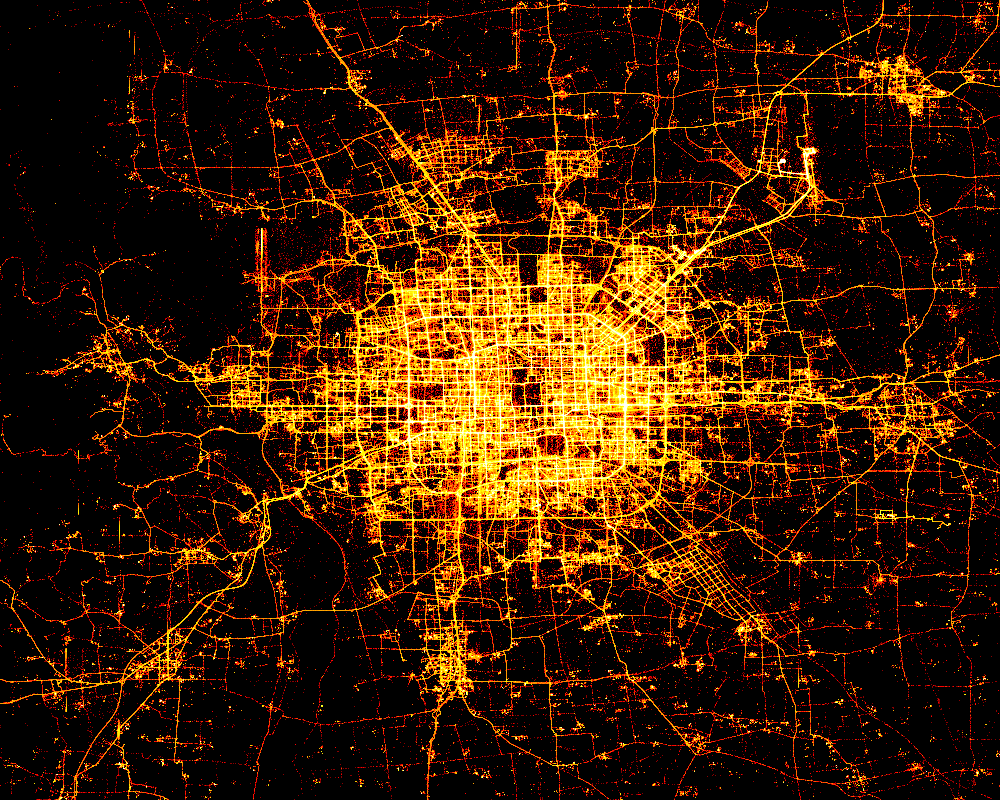

In [75]:
background = "black"
export = partial(export_image, background = background)
cm = partial(colormap_select, reverse=(background!="black"))
cvs = ds.Canvas(plot_width=1000, plot_height=800)
agg = cvs.points(trips_clipped, 'end_lon', 'end_lat')
print "Beijing Taxi Dropoffs"
export(tf.shade(agg, cmap = cm(Hot,0.2), how='eq_hist'),"passenger_count")

# Predict Pickups with LSTM

In [ ]:
def frame_pickups_for_LSTM(df):
    output = pd.DataFrame()
    output['taxi_id'] = df['taxi_id']
    output['start_time'] = df['start_time']
    output['start_lat'] = df['start_lat']
    output['start_lon'] = df['start_lon']
    output.index = df['']

In [ ]:
trips['end_time'] = trips['date_time'].shift(-1)
trips['end_lat'] = trips['latitude'].shift(-1)
trips['end_lon'] = trips['longitude'].shift(-1)

# Look at first two days only

In [18]:
day1 = data[data['date_time'] < pd.to_datetime("2008-02-04 00:02:00")]

In [19]:
day1.shape

(4649416, 9)

In [20]:
day1.head()

,taxi_id,date_time,longitude,latitude,end_time,end_lat,end_lon,taxi_id_prev,id_check
0,1,2008-02-02 15:36:08,116.51172,39.92123,2008-02-02 15:46:08,39.93883,116.51135,1,True
1,1,2008-02-02 15:46:08,116.51135,39.93883,2008-02-02 15:46:08,39.93883,116.51135,1,True
2,1,2008-02-02 15:46:08,116.51135,39.93883,2008-02-02 15:56:08,39.91034,116.51627,1,True
3,1,2008-02-02 15:56:08,116.51627,39.91034,2008-02-02 16:06:08,39.91248,116.47186,1,True
4,1,2008-02-02 16:06:08,116.47186,39.91248,2008-02-02 16:16:08,39.92498,116.47217,1,True


In [21]:
day1['end_time'] = day1['date_time'].shift(-1)
day1['end_lat'] = day1['latitude'].shift(-1)
day1['end_lon'] = day1['longitude'].shift(-1)

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pand

In [22]:
day1.head()

,taxi_id,date_time,longitude,latitude,end_time,end_lat,end_lon,taxi_id_prev,id_check
0,1,2008-02-02 15:36:08,116.51172,39.92123,2008-02-02 15:46:08,39.93883,116.51135,1,True
1,1,2008-02-02 15:46:08,116.51135,39.93883,2008-02-02 15:46:08,39.93883,116.51135,1,True
2,1,2008-02-02 15:46:08,116.51135,39.93883,2008-02-02 15:56:08,39.91034,116.51627,1,True
3,1,2008-02-02 15:56:08,116.51627,39.91034,2008-02-02 16:06:08,39.91248,116.47186,1,True
4,1,2008-02-02 16:06:08,116.47186,39.91248,2008-02-02 16:16:08,39.92498,116.47217,1,True


In [23]:
# Drop the last row for each taxi id
day1['taxi_id_prev'] = day1['taxi_id'].shift(-1)
day1['id_check'] = (day1['taxi_id'] == day1['taxi_id_prev'])
day1 = day1[day1['id_check'] == True]

# Clean up data
del day1['taxi_id_prev']
del day1['id_check']
day1 = day1.reset_index(drop=True)
day1.columns = ['taxi_id', 'start_time', 'start_lon', 'start_lat','end_time','end_lat','end_lon']

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [24]:
day1.head()

,taxi_id,start_time,start_lon,start_lat,end_time,end_lat,end_lon
0,1,2008-02-02 15:36:08,116.51172,39.92123,2008-02-02 15:46:08,39.93883,116.51135
1,1,2008-02-02 15:46:08,116.51135,39.93883,2008-02-02 15:46:08,39.93883,116.51135
2,1,2008-02-02 15:46:08,116.51135,39.93883,2008-02-02 15:56:08,39.91034,116.51627
3,1,2008-02-02 15:56:08,116.51627,39.91034,2008-02-02 16:06:08,39.91248,116.47186
4,1,2008-02-02 16:06:08,116.47186,39.91248,2008-02-02 16:16:08,39.92498,116.47217


In [26]:
# Calculate duration
day1['duration'] = (day1['end_time'] - day1['start_time']).dt.total_seconds()

In [27]:
day1.to_csv("/Users/will/Documents/OpenFrameworks/apps/myApps/BeijingTaxiTrips/bin/data/taxi_trips_clean.csv")

In [3]:
def calculate__bearing(pointA, pointB):
    """
    Calculates the bearing between two points.
    The formulae used is the following:
        θ = atan2(sin(Δlong).cos(lat2),
                  cos(lat1).sin(lat2) − sin(lat1).cos(lat2).cos(Δlong))
    :Parameters:
      - `pointA: The tuple representing the latitude/longitude for the
        first point. Latitude and longitude must be in decimal degrees
      - `pointB: The tuple representing the latitude/longitude for the
        second point. Latitude and longitude must be in decimal degrees
    :Returns:
      The bearing in degrees
    :Returns Type:
      float
    """
    if (type(pointA) != tuple) or (type(pointB) != tuple):
        raise TypeError("Only tuples are supported as arguments")

    lat1 = math.radians(pointA[0])
    lat2 = math.radians(pointB[0])

    diffLong = math.radians(pointB[1] - pointA[1])

    x = math.sin(diffLong) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1)
            * math.cos(lat2) * math.cos(diffLong))

    initial_bearing = math.atan2(x, y)

    # Now we have the initial bearing but math.atan2 return values
    # from -180° to + 180° which is not what we want for a compass bearing
    # The solution is to normalize the initial bearing as shown below
    initial_bearing = math.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

In [ ]:
# Calculate bearing
#day1['bearing'] = day1.apply(lambda row: calculate__bearing((row['start_lat'], row['start_lon']), (row['end_lat'], row['end_lon'])))